In [8]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# MPC import
import numpy as np
import matplotlib.pyplot as plt
from LinearMPC.MPCVelControl import MPCVelControl
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

In [ ]:
Ts = 0.05
sim_time = 7.0
H = 5.0
x0 = np.array([             # initial state for testing (12 states)
    0, 0, 0,                # angular velocities wx, wy, wz
    0, 0, 0,                # Euler angles α, β, γ
    0, 0, -2,                # velocities vx, vy, vz 
    0, 3, 10                 # position x, y, z
])  # initial state

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
mpc = MPCVelControl().new_controller(rocket, Ts, H)


t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, _ = rocket.simulate_control(
    mpc, sim_time, H, x0, method="linear"
)


vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(t_cl[:-1], x_cl[:, :-1], u_cl, T_ol=t_ol[..., :-1], X_ol=x_ol, U_ol=u_ol);


Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
Simulating time 0.30: 
Simulating time 0.35: 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
Simulating time 0.90: 
Simulating time 0.95: 
Simulating time 1.00: 
Simulating time 1.05: 
Simulating time 1.10: 
Simulating time 1.15: 
Simulating time 1.20: 
Simulating time 1.25: 
Simulating time 1.30: 
Simulating time 1.35: 
Simulating time 1.40: 
Simulating time 1.45: 
Simulating time 1.50: 
Simulating time 1.55: 
Simulating time 1.60: 
Simulating time 1.65: 
Simulating time 1.70: 
Simulating time 1.75: 
Simulating time 1.80: 
Simulating time 1.85: 
Simulating time 1.90: 
Simulating time 1.95: 
Simulating time 2.00: 
Simulating time 2.05: 
Simulating time 2.10: 
Simulating 

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=139, step=2), IntSlider(value=0…

{'fig': <Figure size 640x480 with 16 Axes>,
 'axes': [<Axes: ylabel='inputs'>,
  <Axes: >,
  <Axes: >,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Y'}>,
  <Axes: title={'center': 'Subsystem X'}, ylabel='$\\omega_{\\alpha\\beta\\gamma}$ (deg/s)'>,
  <Axes: title={'center': 'Subsystem Roll'}>,
  <Axes: >,
  <Axes: ylabel='$\\alpha\\beta\\gamma$ (deg)'>,
  <Axes: >,
  <Axes: ylabel='$v$ (m/s)'>,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Z'}>,
  <Axes: ylabel='$\\text{pos}$ (m)'>,
  <Axes: >,
  <Axes: >],
 'plotter': <pyvista.plotting.plotter.Plotter at 0x16b895910>,
 'scene_objects': {'rocket_actor': Actor (0x16b872b60)
    Center:                     (0.32006999999999997, 2.9984915, 10.5884845)
    Pickable:                   True
    Position:                   (0.0, 0.0, 0.0)
    Scale:                      (1.0, 1.0, 1.0)
    Visible:                    True
    X Bounds                    -6.402E-01, 1.280E+00
    Y Bounds                    1.788E+00, 4.209E+00
    Z Bou

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

def _poly_dim(Xf):

    return Xf.A.shape[1]

def _interval_bounds_1d(Xf):
    
    A = Xf.A.reshape(-1, 1)
    b = Xf.b.reshape(-1)

    # min x
    res_min = linprog(c=[1.0], A_ub=A, b_ub=b, bounds=[(None, None)], method="highs")

    res_max = linprog(c=[-1.0], A_ub=A, b_ub=b, bounds=[(None, None)], method="highs")

    if (not res_min.success) or (not res_max.success):
        raise RuntimeError("LP failed while computing 1D bounds for Xf.")

    xmin = res_min.x[0]
    xmax = -res_max.fun
    return xmin, xmax

def plot_terminal_set(Xf, title="Xf", dims_to_plot=None, state_labels=None):
    """
    dims_to_plot:
      - None => choix automatique "pertinent pour le deliverable"
      - sinon liste de tuples, ex: [(0,1), (1,2)]
    state_labels: liste de noms d'états pour axes, ex: ["ωy","β","vx"]
    """
    n = _poly_dim(Xf)

    # --- 1D: intervalle ---
    if n == 1:
        xmin, xmax = _interval_bounds_1d(Xf)
        fig, ax = plt.subplots()
        ax.hlines(0, xmin, xmax)
        ax.plot([xmin, xmax], [0, 0], marker="|", linestyle="None")
        ax.set_title(f"{title} (1D)")
        ax.set_yticks([])
        ax.set_xlabel(state_labels[0] if state_labels else "x")
        ax.grid(True)
        return

    # --- 2D: plot direct ---
    if n == 2:
        fig, ax = plt.subplots()
        Xf.plot(ax)
        ax.set_title(f"{title} (2D)")
        if state_labels:
            ax.set_xlabel(state_labels[0]); ax.set_ylabel(state_labels[1])
        ax.grid(True)
        return

    # --- >=3D: projections ---
    if dims_to_plot is None:
        # choix "pertinent deliverable":
        # - au minimum (0,1) et (1,2) comme demandé
        # - si exactement 3D, on ajoute (0,2) (souvent très parlant)
        dims_to_plot = [(0,1), (1,2)]
        if n == 3:
            dims_to_plot.append((0,2))

    for (i, j) in dims_to_plot:
        fig, ax = plt.subplots()
        Xf.projection(dims=(i, j)).plot(ax)
        ax.set_title(f"{title} projection ({i},{j})")
        if state_labels:
            ax.set_xlabel(state_labels[i]); ax.set_ylabel(state_labels[j])
        ax.grid(True)


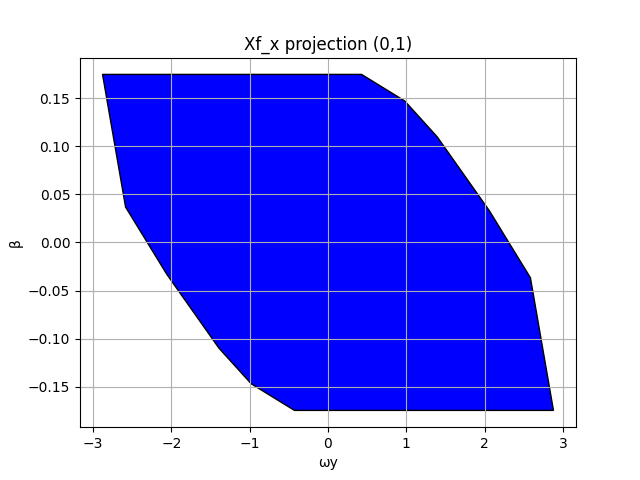

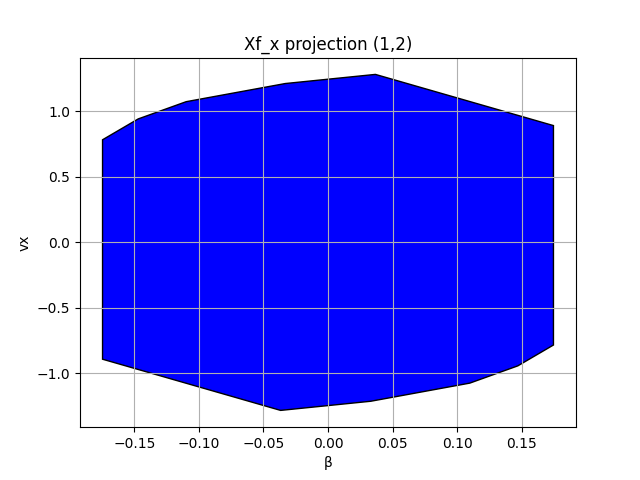

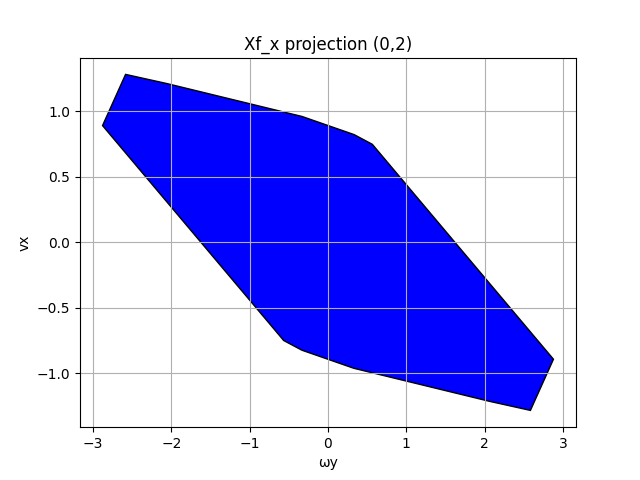

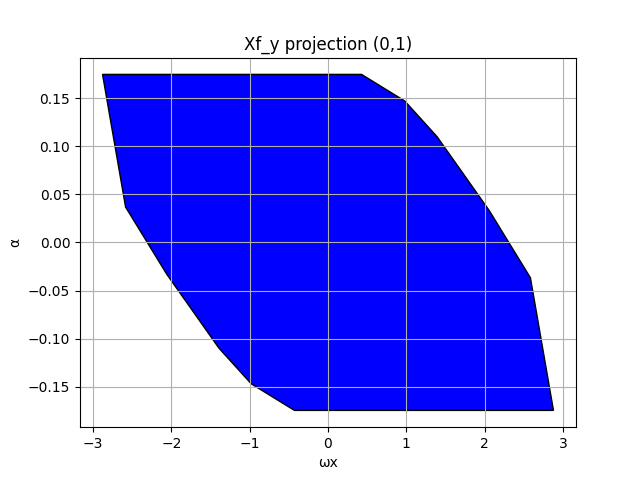

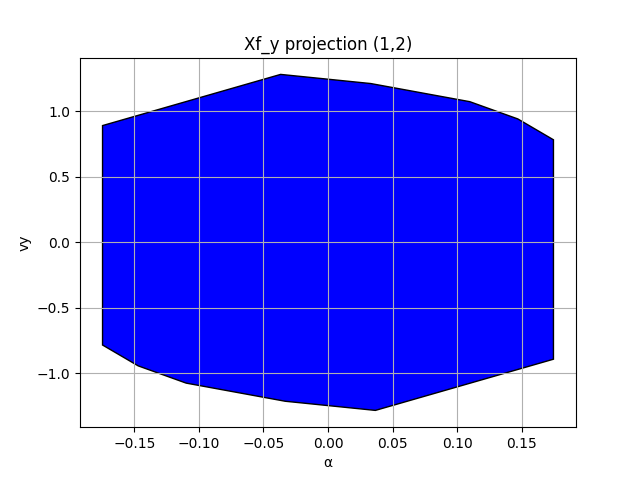

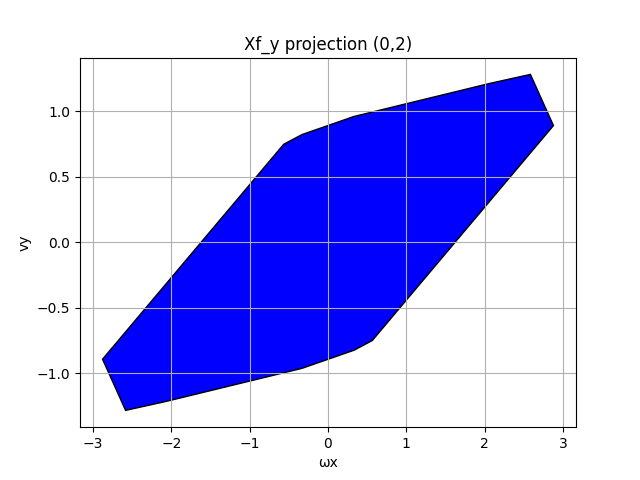

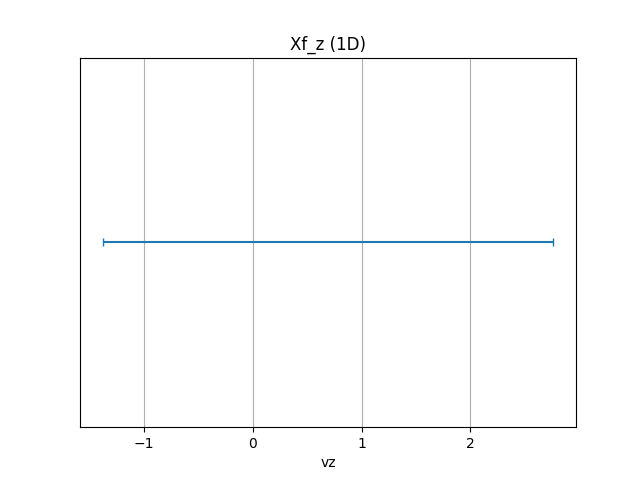

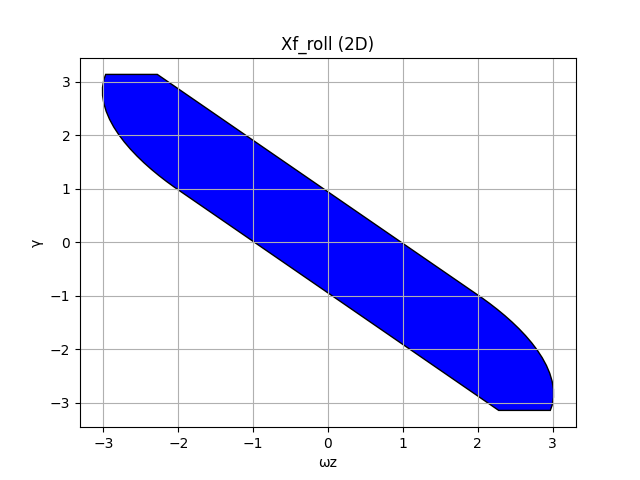

In [15]:
# x-vel: [ωy, β, vx]
plot_terminal_set(mpc.mpc_x.Xf, title="Xf_x", state_labels=["ωy", "β", "vx"])

# y-vel: [ωx, α, vy]
plot_terminal_set(mpc.mpc_y.Xf, title="Xf_y", state_labels=["ωx", "α", "vy"])

# z-vel: [vz]  (1D)
plot_terminal_set(mpc.mpc_z.Xf, title="Xf_z", state_labels=["vz"])

# roll: [ωz, γ] (2D)
plot_terminal_set(mpc.mpc_roll.Xf, title="Xf_roll", state_labels=["ωz", "γ"])


In [29]:
import numpy as np

def check_invariance(Xf, Acl, ntests=2000):
    # échantillonne des points dans Xf via des LP sur des directions aléatoires (simple mais efficace)
    # on prend juste des points “sur les bords” en max/min dans des directions
    from scipy.optimize import linprog

    A = Xf.A
    b = Xf.b
    n = A.shape[1]

    for _ in range(ntests):
        c = np.random.randn(n)
        # max c^T x  <=>  min -c^T x
        res = linprog(c=-c, A_ub=A, b_ub=b, bounds=[(None,None)]*n, method="highs")
        if not res.success:
            continue
        x = res.x
        x_next = Acl @ x

        # vérifie x_next ∈ Xf  <=>  A x_next <= b
        if np.any(A @ x_next > b -0.3):
            return False
    return True
# Exemple x-subsystem
Acl_x = mpc.mpc_x.A + mpc.mpc_x.B @ mpc.mpc_x.K
print("Xf_x invariant?", check_invariance(mpc.mpc_x.Xf, Acl_x))

# z-subsystem
Acl_z = mpc.mpc_z.A + mpc.mpc_z.B @ mpc.mpc_z.K
print("Xf_z invariant?", check_invariance(mpc.mpc_z.Xf, Acl_z))


Xf_x invariant? False
Xf_z invariant? True


In [25]:
Acl_y = mpc.mpc_y.A + mpc.mpc_y.B @ mpc.mpc_y.K
print("Xf_x invariant?", check_invariance(mpc.mpc_y.Xf, Acl_y))



Xf_x invariant? False


In [30]:
import numpy as np
import matplotlib.pyplot as plt

def _plot_ol_predictions(ax, t_ol, x_ol, idx_state, every=5, alpha=0.15, lw=1.0):
    """
    Plot a subset of open-loop state predictions on a given axis.

    Parameters
    ----------
    ax : matplotlib axis
        Axis to plot on.
    t_ol : array
        Open-loop time grid. Expected shape:
          - (Nsim, Npred)  (predictions available at each closed-loop step), or
          - (Npred,)       (single prediction grid)
    x_ol : array
        Open-loop predicted states. Expected shape:
          - (Nsim, nx, Npred), or
          - (Nsim, Npred, nx)
    idx_state : int
        Index of the state to plot.
    every : int
        Plot one predicted trajectory every `every` closed-loop steps.
    alpha : float
        Transparency for predicted trajectories.
    lw : float
        Line width for predicted trajectories.
    """
    T = np.asarray(t_ol)
    X = np.asarray(x_ol)

    # If no predictions, do nothing
    if X.ndim != 3:
        return

    # Normalize X to shape (Nsim, nx, Npred)
    # If X is (Nsim, Npred, nx), transpose it
    if X.shape[1] != X.shape[1] and X.shape[2] != X.shape[2]:
        pass  # placeholder, never hit (kept for clarity)

    if X.shape[1] != X.shape[1]:
        pass

    if X.shape[1] != X.shape[1]:
        pass

    # The real check:
    if X.shape[1] != X.shape[1]:
        pass

    # Robust check:
    # If second dimension looks like Npred and third like nx, transpose
    # We assume nx is typically 12 and Npred is typically > 12
    if X.shape[1] > 12 and X.shape[2] <= 12:
        # (Nsim, Npred, nx) -> (Nsim, nx, Npred)
        X = np.transpose(X, (0, 2, 1))

    Nsim, nx, Npred = X.shape

    # Normalize T to shape (Nsim, Npred)
    if T.ndim == 1:
        # Single time grid: reuse for all k
        T = np.tile(T.reshape(1, -1), (Nsim, 1))
    elif T.ndim == 2:
        pass
    else:
        return

    # Plot selected open-loop predictions
    for k in range(0, Nsim, every):
        ax.plot(T[k, :], X[k, idx_state, :], alpha=alpha, linewidth=lw)


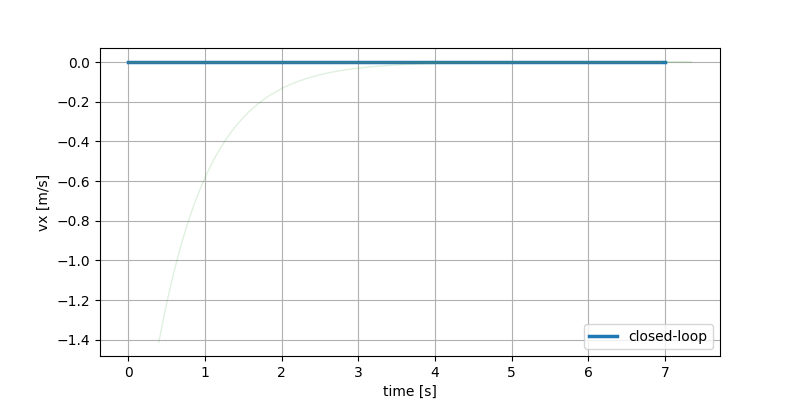

In [31]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(t_cl, x_cl[6, :], linewidth=2.5, label="closed-loop")
_plot_ol_predictions(ax, t_ol, x_ol, idx_state=6, every=8)
ax.set_xlabel("time [s]")
ax.set_ylabel("vx [m/s]")
ax.grid(True)
ax.legend()
plt.show()
